#  과제2-1. 수어번역기 모델링 및 추적(개인과제)

## 1.환경준비

### (1) 라이브러리 로딩

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import mlflow
import mlflow.keras

In [2]:
np.set_printoptions(linewidth=np.inf)

* 함수 만들기

In [3]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

#### 1) 데이터 가져오기
* 제공 받은 데이터를 여러분의 구글드라이브 적절한 위치에 업로드 합니다.
    * 가능하면, 구글드라이브 첫 경로 밑에 폴더를 만들고 업로드 하기를 권장합니다.

In [4]:
path = 'data/'
file = 'sign_language.csv'

data = pd.read_csv(path+file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [5]:
data.shape

(8000, 785)

#### 2) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [6]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

### (3) mlflow 추적 준비

In [7]:
mlflow_uri = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(mlflow_uri)

### (4) 새 실험 생성
* exp4

In [8]:
exp_id = mlflow.create_experiment("exp4")

## 2 데이터 살펴보기

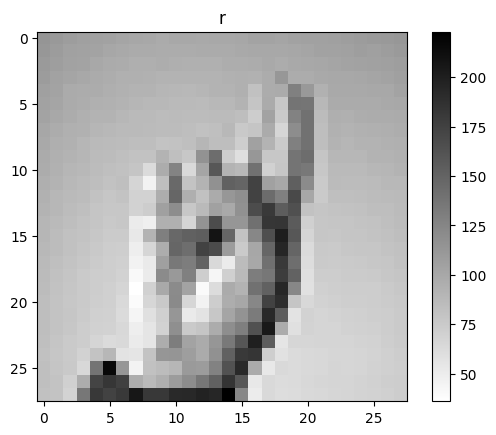

In [9]:
# 아래 숫자를 바꿔가며 화면에 그려 봅시다.
n = 100
sign_fig = data.iloc[n, 1:].values
sign_fig = sign_fig.reshape(28, 28)

sign = class_names[data.iloc[n,0]]

plt.title(sign)
plt.imshow(255-sign_fig, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

## 3.데이터 준비

* 주어진 데이터셋
    * 2차원 데이터셋, 1차원 데이터포인트(분석단위, 예측단위) 입니다. 
    * 흑백 이미지데이터
    * 이 데이터로부터 데이터 준비작업을 수행합니다.
        * 데이터 분할1 : x, y
        * 데이터 분할2 : train, validation
        * 만약 CNN으로 모델링을 한다면, shape를 맞춰야 합니다. (n, 28, 28, 1) 
        * scaling
* 그러나 운영에서 발생될 데이터는 이미지 한장 한장 입니다. 이미지 한장, 한장 들어온다면 어떻게 데이터가 처리되어야 할까요?(Data Pipeline 구성)

### (1) 데이터 분할1 : x, y 나누기

In [11]:
x = data.drop('label', axis=1).values
y = data.loc[:, 'label'].values

### (2) 데이터 분할2 : train, validation, test

* train : val : test = 5000 : 2000 : 1000
* 여기서 test set은 파이프라인 점검을 위한 용도로 사용합니다.

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1000, random_state=2023)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=2000, random_state=2023)

In [13]:
x_train.shape, x_val.shape, x_test.shape

((5000, 784), (2000, 784), (1000, 784))

### (3) DL을 위한 전처리
* 모두 넘파이로 변환

* shape 맞추기 n, 28,28,1
    * reshape
        * x_train.shape : (-1, 28, 28, 1)
        * x_val.shape : (-1, 28, 28, 1)
        * x_test.shape : (-1, 28, 28, 1)

In [14]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

* Scaling : Min-Max
    * 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
    * x_train2, x_val2 를 그냥 255로 나누면 됨

In [15]:
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

## 4.모델링

### (1) 모델1

In [22]:
with mlflow.start_run(experiment_id=exp_id):
    mlflow.keras.autolog()
    clear_session()

    model = Sequential([Conv2D(16, kernel_size=3, input_shape=(28, 28, 1), padding='same', strides =1, activation='relu'),
                        MaxPooling2D(pool_size=2, strides=2),
                        Flatten(),
                        Dense(128, activation = 'relu'),
                        Dense(26, activation='softmax')
    ])

    model.summary()

    # 컴파일
    model.compile(loss='sparse_categorical_crossentropy',
                metrics=['accuracy'],
                optimizer='adam')
    es = EarlyStopping(
        patience=5,
        min_delta=0,
        verbose=1
    )
    history = model.fit(x_train, y_train, validation_split=0.2,
                    epochs=30, batch_size=256, callbacks=[es]).history
    
    val_pred = model.predict(x_val).argmax(axis=1)
    val_acc = accuracy_score(y_val, val_pred)
    mlflow.log_metric("val_accuracy", val_acc)
    mlflow.keras.log_model(model, "keras-model", registered_model_name="DL")    
    mlflow.keras.autolog(disable=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               401536    
                                                                 
 dense_1 (Dense)             (None, 26)                3354      
                                                                 
Total params: 405,050
Trainable params: 405,050
Non-trainable params: 0
__________________________________________________

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpvr95oy8i\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpvr95oy8i\model\data\model\assets


63/63 [==============================] - 0s 3ms/step


2023/05/18 15:14:48 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp38k42y2n\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp38k42y2n\model\data\model\assets
Registered model 'DL' already exists. Creating a new version of this model...
2023/05/18 15:14:55 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DL, version 3
Created version '3' of model 'DL'.


* 학습곡선

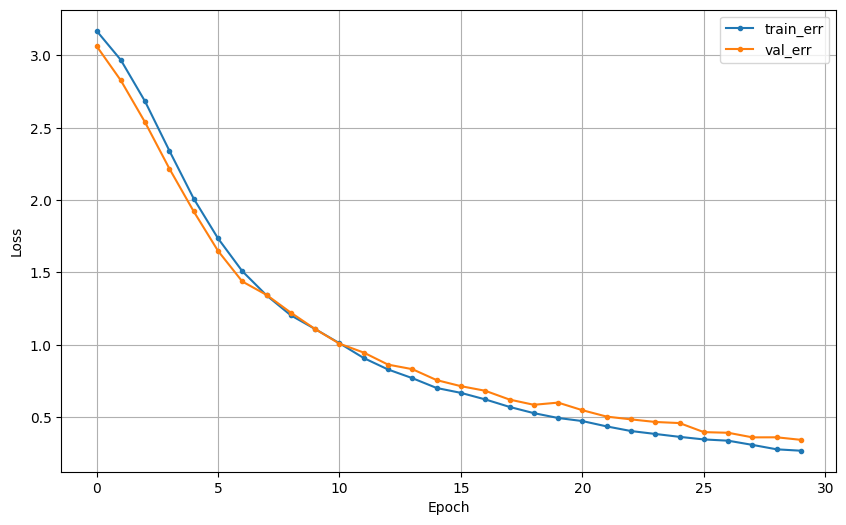

In [23]:
dl_history_plot(history)

* 예측 및 검증

In [ ]:
y_pred = model.predict(x_val).argmax(axis=1)
print(confusion_matrix(y_val, y_pred))
print(classification_report(class_names[y_val], class_names[y_pred]))

### (2) 모델2

In [26]:
with mlflow.start_run(experiment_id=exp_id):
    mlflow.keras.autolog()
    clear_session()

    # 모델 쌓기
    il = Input(shape=(28, 28, 1))

    hl = Conv2D(32, (3, 3), activation='relu', padding='same')(il)
    hl = Conv2D(32, (3, 3), activation='relu', padding='same')(hl)
    hl = BatchNormalization()(hl)
    hl = MaxPooling2D()(hl)
    hl = Dropout(0.2)(hl)

    hl = Conv2D(64, (3, 3), activation='relu', padding='same')(il)
    hl = Conv2D(64, (3, 3), activation='relu', padding='same')(hl)
    hl = BatchNormalization()(hl)
    hl = MaxPooling2D()(hl)
    hl = Dropout(0.2)(hl)

    hl = Flatten()(hl)
    hl = Dense(512, activation='relu')(hl)
    hl = Dropout(0.2)(hl)
    ol = Dense(26, activation='softmax')(hl)

    # 모델 선언
    model = Model(il, ol)

    # 컴파일
    model.compile(loss='sparse_categorical_crossentropy',
                metrics=['accuracy'],
                optimizer='adam')
    es = EarlyStopping(
        patience=5,
        min_delta=0,
        verbose=1
    )
    history = model.fit(x_train, y_train, validation_split=0.2,
                    epochs=30, batch_size=256, callbacks=[es]).history
    
    val_pred = model.predict(x_val).argmax(axis=1)
    val_acc = accuracy_score(y_val, val_pred)
    mlflow.log_metric("val_accuracy", val_acc)
    mlflow.keras.log_model(model, "keras-model", registered_model_name="DL")    
    mlflow.keras.autolog(disable=True)

Epoch 1/30
16/16 [==============================] - 25s 1s/step - loss: 2.6167 - accuracy: 0.3577 - val_loss: 3.0664 - val_accuracy: 0.0810
Epoch 2/30
16/16 [==============================] - 17s 1s/step - loss: 0.6967 - accuracy: 0.7910 - val_loss: 2.8313 - val_accuracy: 0.4250
Epoch 3/30
16/16 [==============================] - 13s 781ms/step - loss: 0.2009 - accuracy: 0.9390 - val_loss: 2.5862 - val_accuracy: 0.5760
Epoch 4/30
16/16 [==============================] - 12s 786ms/step - loss: 0.0631 - accuracy: 0.9843 - val_loss: 2.3920 - val_accuracy: 0.7330
Epoch 5/30
16/16 [==============================] - 15s 917ms/step - loss: 0.0250 - accuracy: 0.9952 - val_loss: 2.2317 - val_accuracy: 0.9280
Epoch 6/30
16/16 [==============================] - 18s 1s/step - loss: 0.0138 - accuracy: 0.9975 - val_loss: 2.0720 - val_accuracy: 0.8600
Epoch 7/30
16/16 [==============================] - 22s 1s/step - loss: 0.0094 - accuracy: 0.9995 - val_loss: 1.9459 - val_accuracy: 0.9040
Epoch 8/30


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpgtpawgjo\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpgtpawgjo\model\data\model\assets


63/63 [==============================] - 2s 31ms/step


2023/05/18 15:24:26 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp7vatiyj5\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp7vatiyj5\model\data\model\assets
Registered model 'DL' already exists. Creating a new version of this model...
2023/05/18 15:24:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DL, version 4
Created version '4' of model 'DL'.


* 학습곡선

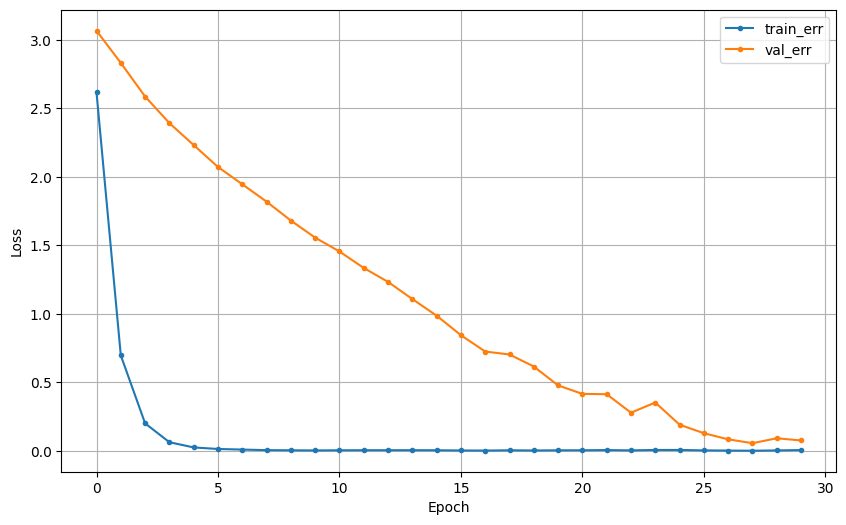

In [27]:
dl_history_plot(history)

* 예측 및 검증

In [30]:
y_pred = model.predict(x_val).argmax(axis=1)
print(confusion_matrix(y_val, y_pred))
print(classification_report(class_names[y_val], class_names[y_pred]))

63/63 [==============================] - 1s 20ms/step
[[87  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 78  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 87  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 98  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 82  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0 89  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 73  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 75  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 85  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 97  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 69  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 81  0  0

### (2) 모델3

In [32]:
with mlflow.start_run(experiment_id=exp_id):
    mlflow.keras.autolog()
    clear_session()

    # 모델 쌓기
    il = Input(shape=(28, 28, 1))

    hl = Conv2D(32, (3, 3), activation='relu', padding='same')(il)
    hl = Conv2D(32, (3, 3), activation='relu', padding='same')(hl)
    hl = BatchNormalization()(hl)
    hl = MaxPooling2D()(hl)
    hl = Dropout(0.2)(hl)
    
    hl = Flatten()(hl)
    hl = Dense(512, activation='relu')(hl)
    hl = Dropout(0.2)(hl)
    ol = Dense(26, activation='softmax')(hl)

    # 모델 선언
    model = Model(il, ol)

    # 컴파일
    model.compile(loss='sparse_categorical_crossentropy',
                metrics=['accuracy'],
                optimizer='adam')
    es = EarlyStopping(
        patience=5,
        min_delta=0,
        verbose=1
    )
    history = model.fit(x_train, y_train, validation_split=0.2,
                    epochs=30, batch_size=256, callbacks=[es]).history
    
    val_pred = model.predict(x_val).argmax(axis=1)
    val_acc = accuracy_score(y_val, val_pred)
    mlflow.log_metric("val_accuracy", val_acc)
    mlflow.keras.log_model(model, "keras-model", registered_model_name="DL")    
    mlflow.keras.autolog(disable=True)

Epoch 1/30
16/16 [==============================] - 10s 516ms/step - loss: 2.4350 - accuracy: 0.3762 - val_loss: 3.0318 - val_accuracy: 0.3050
Epoch 2/30
16/16 [==============================] - 8s 480ms/step - loss: 0.7492 - accuracy: 0.7745 - val_loss: 2.8031 - val_accuracy: 0.7160
Epoch 3/30
16/16 [==============================] - 8s 491ms/step - loss: 0.2689 - accuracy: 0.9212 - val_loss: 2.6320 - val_accuracy: 0.8510
Epoch 4/30
16/16 [==============================] - 7s 448ms/step - loss: 0.1071 - accuracy: 0.9722 - val_loss: 2.3939 - val_accuracy: 0.9090
Epoch 5/30
16/16 [==============================] - 6s 387ms/step - loss: 0.0429 - accuracy: 0.9900 - val_loss: 2.2534 - val_accuracy: 0.9770
Epoch 6/30
16/16 [==============================] - 6s 350ms/step - loss: 0.0245 - accuracy: 0.9958 - val_loss: 2.1005 - val_accuracy: 0.9770
Epoch 7/30
16/16 [==============================] - 5s 332ms/step - loss: 0.0145 - accuracy: 0.9980 - val_loss: 1.9629 - val_accuracy: 0.9780
Epoch

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp9vg4pci3\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp9vg4pci3\model\data\model\assets


63/63 [==============================] - 1s 19ms/step


2023/05/18 15:36:27 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpl5qfeobf\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpl5qfeobf\model\data\model\assets
Registered model 'DL' already exists. Creating a new version of this model...
2023/05/18 15:36:35 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DL, version 5
Created version '5' of model 'DL'.


* 학습곡선

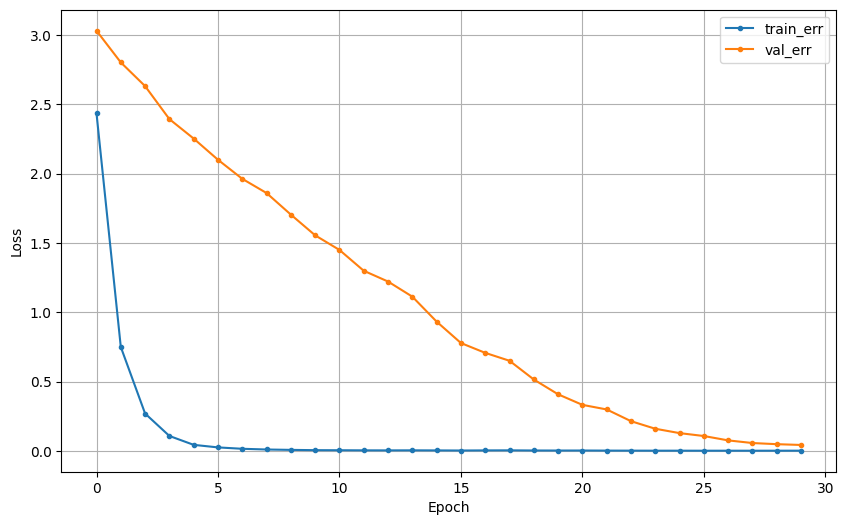

In [33]:
dl_history_plot(history)

* 예측 및 검증

In [34]:
y_pred = model.predict(x_val).argmax(axis=1)
print(confusion_matrix(y_val, y_pred))
print(classification_report(class_names[y_val], class_names[y_pred]))

63/63 [==============================] - 1s 17ms/step
[[87  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 78  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 87  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 98  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 82  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0 89  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 73  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 75  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 85  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 97  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 69  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 81  0  0

### (2) 모델4

In [51]:
with mlflow.start_run(experiment_id=exp_id):
    mlflow.keras.autolog()
    clear_session()

    # 모델 쌓기
    il = Input(shape=(28, 28, 1))

    hl = Conv2D(32, (3, 3), activation='relu', padding='same')(il)
    hl = Conv2D(32, (3, 3), activation='relu', padding='same')(hl)
    hl = BatchNormalization()(hl)
    hl = MaxPooling2D()(hl)
    hl = Dropout(0.2)(hl)
    
    hl = Flatten()(hl)
    hl = Dense(128, activation='relu')(hl)
    hl = Dropout(0.2)(hl)
    ol = Dense(26, activation='softmax')(hl)

    # 모델 선언
    model = Model(il, ol)

    # 컴파일
    model.compile(loss='sparse_categorical_crossentropy',
                metrics=['accuracy'],
                optimizer='adam')
    es = EarlyStopping(
        patience=5,
        min_delta=0,
        verbose=1
    )
    history = model.fit(x_train, y_train, validation_split=0.2,
                    epochs=30, batch_size=256, callbacks=[es]).history
    
    val_pred = model.predict(x_val).argmax(axis=1)
    val_acc = accuracy_score(y_val, val_pred)
    mlflow.log_metric("val_accuracy", val_acc)
    mlflow.keras.log_model(model, "keras-model", registered_model_name="DL")    
    mlflow.keras.autolog(disable=True)

Epoch 1/30
16/16 [==============================] - 3s 159ms/step - loss: 2.6495 - accuracy: 0.2607 - val_loss: 3.1377 - val_accuracy: 0.2910
Epoch 2/30
16/16 [==============================] - 3s 158ms/step - loss: 1.2056 - accuracy: 0.6395 - val_loss: 2.9181 - val_accuracy: 0.4710
Epoch 3/30
16/16 [==============================] - 3s 171ms/step - loss: 0.4911 - accuracy: 0.8482 - val_loss: 2.6934 - val_accuracy: 0.8360
Epoch 4/30
16/16 [==============================] - 3s 177ms/step - loss: 0.2180 - accuracy: 0.9367 - val_loss: 2.5496 - val_accuracy: 0.9510
Epoch 5/30
16/16 [==============================] - 3s 194ms/step - loss: 0.0963 - accuracy: 0.9765 - val_loss: 2.3313 - val_accuracy: 0.9690
Epoch 6/30
16/16 [==============================] - 3s 173ms/step - loss: 0.0614 - accuracy: 0.9852 - val_loss: 2.2182 - val_accuracy: 0.9790
Epoch 7/30
16/16 [==============================] - 3s 176ms/step - loss: 0.0432 - accuracy: 0.9900 - val_loss: 2.0915 - val_accuracy: 0.9860
Epoch 

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmphry1df3w\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmphry1df3w\model\data\model\assets


63/63 [==============================] - 1s 10ms/step


2023/05/18 15:57:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpjn3w0662\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpjn3w0662\model\data\model\assets
Registered model 'DL' already exists. Creating a new version of this model...
2023/05/18 15:57:23 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DL, version 6
Created version '6' of model 'DL'.


* 학습곡선

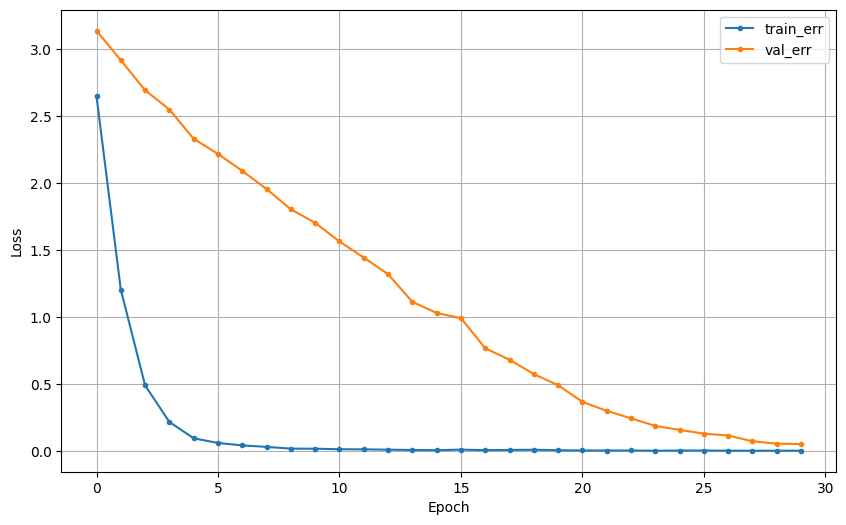

In [52]:
dl_history_plot(history)

* 예측 및 검증

In [53]:
y_pred = model.predict(x_val).argmax(axis=1)
print(confusion_matrix(y_val, y_pred))
print(classification_report(class_names[y_val], class_names[y_pred]))

63/63 [==============================] - 1s 22ms/step
[[87  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 78  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 87  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 98  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 85  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 89  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 73  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 75  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 85  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 97  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 66  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 81  0  0

## 5.모델 사용하기
* 가장 성능이 좋은 모델 production 지정
* Production 모델 호출해서 test 셋으로 예측 및 평가



In [35]:
model_uri = "models:/DL/production" 
model = mlflow.keras.load_model(model_uri)

In [36]:
y_pred = model.predict(x_test).argmax(axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(class_names[y_test], class_names[y_pred]))

32/32 [==============================] - 0s 10ms/step
[[44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 51  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 57  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 43  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 39  0  0